[![PALS0039 Logo](https://www.phon.ucl.ac.uk/courses/pals0039/images/pals0039logo.png)](https://www.phon.ucl.ac.uk/courses/pals0039/)

# Exercise 7.2 Language modelling using RNNs

In this exercise we replicate our language modelling experiment from 7.1 but use an RNN instead of n-gram models.




In [1]:
import nltk
import pandas as pd

# Test if NLTK downloads work correctly
nltk.download("reuters")
nltk.download("punkt")

# Test if Pandas works
print(pd.__version__)

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


2.2.2


In [2]:
nltk.download("reuters")
nltk.download("punkt_tab")
from nltk.corpus import reuters
from nltk.lm import Vocabulary
# .util = utility functions
from nltk.util import pad_sequence, ngrams
from nltk.lm.preprocessing import flatten
from nltk.lm.models import Laplace

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
# TimeDistributed connects fnn with lstm ?
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


1. ***Collect*** all the sentences from the `reuters` corpus, ***lowercase*** them, and ***pad*** the start and end with special symbols (this means we will have n-grams that distinguish the start and end of sentences). For the left pad symbol use `<s>` and the right use `</s>`.

2. ***Flatten*** the sentences into a single list of words representing the entire corpus and create a finite vocabulary by specifying a frequency cut-off at 10.

3. ***Partition*** the text into `train` and `test` sets as follows: reserve the first 10,000 words for the `test` set and the rest for `train`.

In [3]:
# 1. Collect, lowercase and pad:
# Create empty list of sentences
sentences = []
# Iterate through reuters database sentences -> .sents()
for s in reuters.sents():
  # lowercase each word
  lower_s = [word.lower() for word in s]
  # implement padding with pad_sequence from nltk with starting and end symbol
  padded_lower_s = list(pad_sequence(lower_s,
                                     n=2,
                                     pad_left=True,
                                     left_pad_symbol="<s>",
                                     pad_right=True,
                                     right_pad_symbol="</s>"))
  # this makes list distinguishable between sentences
  sentences.append(padded_lower_s)

# 2. Flatten and create finite vocabulary
# flatten -> makes one single list out of a list of lists
words = list(flatten(sentences))
# create vocabulary with nltk toolkit class and define OOV with unk_cutoff=10
vocab = Vocabulary(words, unk_cutoff=10)

# 3. Partition into train and test
test_words = words[:10000]
train_words = words[10000:]

#Inspect
print("Length of corpus:", len(words))
print("Length of vocabulary:", len(vocab))
print("Unique words in corpus:", len(set(words)))

Length of corpus: 1830349
Length of vocabulary: 8070
Unique words in corpus: 31079


Create mapping from words to indices and map the train and test word sequences:

In [4]:
# Create mapping -> add more comments! What are you mapping?
# A dictionary that maps between words (w) and index (i)
word_to_index = {w: i for i, w in enumerate(vocab)}

# Map data -> Create data for neural network (list of indices)
train_indices = [word_to_index[vocab.lookup(w)] for w in train_words]
test_indices = [word_to_index[vocab.lookup(w)] for w in test_words]

# Inspect
print(train_indices[:25])
print(test_indices[:25])

[1820, 157, 1096, 426, 1308, 34, 43, 8069, 430, 22, 15, 526, 42, 55, 42, 541, 826, 16, 1821, 278, 325, 53, 1666, 1822, 74]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 8069, 11, 12, 13, 14, 15, 6, 7, 8, 7, 16, 10, 17, 18]


Prepare the train and test data for use with a RNN:
1. Chunk the sequences into smaller sequence with length 100 words (`seqlen`)
2. Create outputs which are the inputs shifted by 1 word (i.e. the RNN predicts the next word at each time step.

In [5]:
# Define sequence length of 100 words
seqlen = 100

# Create outputs which are shifted by one word
# so that input and output match based on desired predictions
def prepare_sequences(words, unk_index, seqlen=seqlen):
  '''
  Args:
  words: A list (or array) of word indices representing a tokenized text.
  unk_index: The index assigned to unknown words ("<UNK>").
  seqlen: The number of words per sequence (default is 100).
  '''
  '''
  The variable trunc_length finds out how many words would remain if we divided words into chunks of 100.
  It removes the extra words at the beginning (trunc_length) so that the remaining words are exactly divisible by seqlen.
  Then, words is converted into a NumPy array and reshaped into batches of shape (-1, seqlen), meaning:
  -1 lets NumPy infer the number of rows automatically.
  seqlen ensures each row contains 100 words.
  '''
  trunc_length = len(words) % seqlen
  X = np.array(words)[trunc_length:].reshape((-1, seqlen))
  '''
  This shifts the output (y) by one word to the right.
  words + [unk_index]: Adds an extra <UNK> token at the end, ensuring alignment when shifting.
  trunc_length + 1: Offsets by one to make y the "next word" for each corresponding X.
  The result is then reshaped to (-1, seqlen), just like X.
  '''
  y = np.array(words + [unk_index])[trunc_length + 1:].reshape((-1, seqlen))
  return X, y

'''
train_indices and test_indices are lists of word indices.
These are processed into X (input sequences) and y (shifted target sequences).
<UNK> is used as a filler for the last word.
'''
Xtrain, ytrain = prepare_sequences(train_indices, word_to_index["<UNK>"])
Xtest, ytest = prepare_sequences(test_indices, word_to_index["<UNK>"])

#Inspect
print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)

(18203, 100) (18203, 100)
(100, 100) (100, 100)


Define functions for the following:
1. To calculate the perplexity from the inputs and outputs
2. The model architecture


In [13]:
# Define function to calculate perplexity
# Use tf functions
def perplexity(y_true, y_pred):
  cross_entropy = tf.losses.sparse_categorical_crossentropy(y_true, y_pred)
  perplexity = tf.exp(tf.reduce_mean(cross_entropy))
  return perplexity

def build_model(input_width=len(vocab), input_length=seqlen, output_width=len(vocab), learning_rate=0.01):
  model = Sequential()
  model.add(Embedding(input_dim=input_width, output_dim=64, input_shape=(input_length,)))
  model.add(LSTM(32, return_sequences=True, activation='tanh'))
  model.add(LSTM(32, return_sequences=True, activation='tanh'))
  # Without TimeDistributed, the Dense layer would only be applied to the last time step
  model.add(TimeDistributed(Dense(output_width, activation='softmax')));
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=[perplexity])
  return model

model = build_model()

#Inspect
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 64)             │         516,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 32)             │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 100, 8070)           │         266,310 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,526 (3.07 MB)

 Trainable params: 803,526 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

(a) Call the model.fit method with the correct arguments to train the model with the following specifications: (1) Train for 40 iterations over the dataset; (2) Update the weights during training in batches of 64 samples; (3) Request Keras to randomly select 10% of the training set as the validation set. (4) Implement early stopping if the validation set loss does not decrease for 2 epochs.

In [14]:
#(a)
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
device = "CPU"
if tf.config.list_physical_devices('GPU'):
    device = "GPU"
print(f"Using {device} device")

# Setting patience is important, not too short, not too long, difficult param to set?
# Set verbose to 0 in assessment!
training_info = model.fit(Xtrain, ytrain, epochs=40, batch_size=64, validation_split=0.1, callbacks=EarlyStopping(monitor='val_loss', patience=2))

Using GPU device
Epoch 1/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - loss: 6.7323 - perplexity: 1371.0088 - val_loss: 6.3603 - val_perplexity: 580.9601
Epoch 2/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 36s 86ms/step - loss: 6.3494 - perplexity: 572.7315 - val_loss: 6.3601 - val_perplexity: 580.7742
Epoch 3/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - loss: 6.3493 - perplexity: 572.4589 - val_loss: 6.3643 - val_perplexity: 583.2361
Epoch 4/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - loss: 6.3506 - perplexity: 573.3394 - val_loss: 6.3563 - val_perplexity: 578.5546
Epoch 5/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - loss: 6.1601 - perplexity: 488.6968 - val_loss: 5.3657 - val_perplexity: 215.7730
Epoch 6/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - loss: 5.2213 - perplexity: 186.3712 - val_loss: 4.9730 - val_perplexity: 146.0377
Epoch 7/40
256/256 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - loss: 4.8420 - perplexity: 127.2881 - val_loss: 4.7406 - val_perplexity: 116.0199
Epoch 8/40
256/2

---
Plot and examine the training graphs, compare the training and evaluation errors. Run the code.

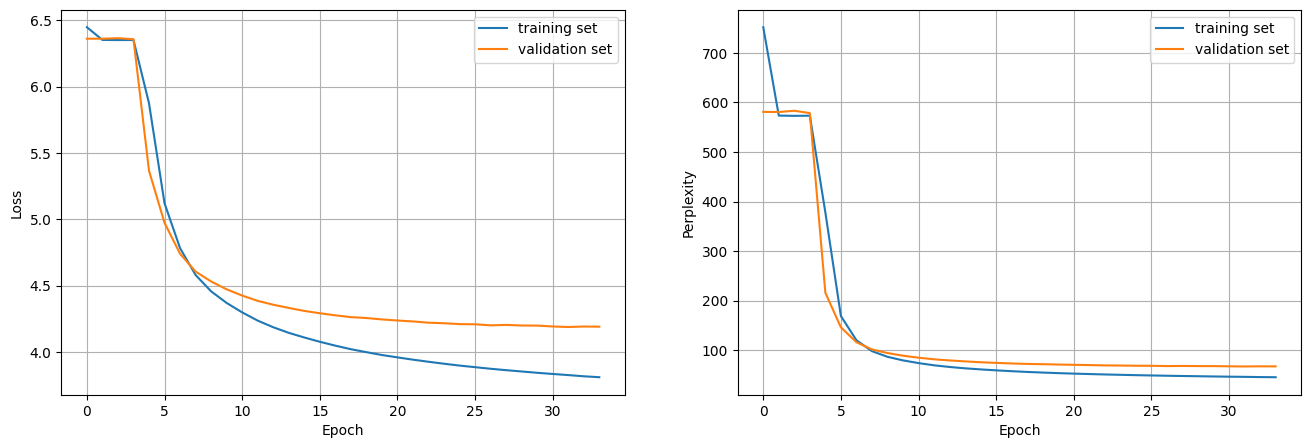

In [15]:
def plot_training_history(training_info):
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))
  axs[0].plot(training_info.history['loss'], label="training set")
  axs[0].plot(training_info.history['val_loss'], label="validation set")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend()
  try:
    axs[1].plot(training_info.history['perplexity'], label="training set")
    axs[1].plot(training_info.history['val_perplexity'], label="validation set")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Perplexity")
    axs[1].grid(True)
    axs[1].legend()
  except:
    pass
  plt.show()

plot_training_history(training_info)

(b) Evaluate the model on the test set and comment on the result compared to Ex. 7.1

In [19]:
#(b)
test_loss, test_accuracy = model.evaluate(Xtest, ytest, verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

# Much lower perplexity than n-gram?

Test loss: 4.370587348937988
Test accuracy: 87.73219299316406


Let's generate a sequence from the model using a partial seed sentence:

In [17]:
from scipy.stats import rv_discrete

# Create index to word mapping by inverting the word to index mapping
index_to_word = {i: w for w, i in word_to_index.items()}

# Choose seed text and create padded index sequence
seed_text = "<s> it is a fact that"
seq = [word_to_index[w] for w in seed_text.split()]
padded_seq = pad_sequences([seq], maxlen=seqlen, padding='post')

# Sample word sequence
for i in range(seqlen - len(seq)):
  full_prediction = model.predict(padded_seq, verbose=0)
  next_word_prediction = full_prediction[0][len(seq) + i, :]
  dpd = rv_discrete(values=(list(range(len(next_word_prediction))), next_word_prediction))
  padded_seq[0][len(seq) + i] = dpd.rvs(size=1)

# Print word sequence
sampled_words = []
for word_index in padded_seq[0]:
  sampled_words.append(index_to_word[word_index])
print(" ".join(sampled_words))

<ipython-input-17-3c179d8b3285>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  padded_seq[0][len(seq) + i] = dpd.rvs(size=1)


<s> it is a fact that transcanada the that it " the from they far the he seven <UNK> & he <UNK> the a on after shareholders congress focusing it the the he it " he of amoco <UNK> it saying bundesbank a in we saying the producer we the real the iraq based they the of by it , <UNK> reports it its barter about last in brokers yesterday that long brazil the from largely calling much they as if when if <UNK> " the today the profits there the kohl they <UNK> the if a of japan necessary
